<a href="https://colab.research.google.com/github/imZiho/Deep-Learning_Seminar/blob/main/CHA07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache direc

In [2]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [3]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [4]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [5]:
# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

# **다중분류**

기존 3개의 붓꽃데이터셋을 2종류로 줄여 이진분류에 사용했지만
여기서는 세 종류 모두 학습 데이터로 사용한다.

(이진분류와의 차이점)

0. 출력부분에서의 큰 차이점 (선형회귀모델이나 이진분류모델 모두 출력은 1차원에 그쳤지만 다중분류모델에서는 분류하려는 그룹의 개수를 N개라고 했을때, N차원 출력이 된다)

1. 이진분류의 예측에서 사용한 시그모이드 함수가 소프트맥스함수로 불리는 별개의 함수로 바뀐다

2. 손실함수는 교차엔트로피 함수 그대로 사용하지만 형식에는 차이가 있다

3. 이진분류에서는 가중치 벡터였으나 다중분류에서는 가중치 행렬로 대체된다

**소프트맥스 함수란?**

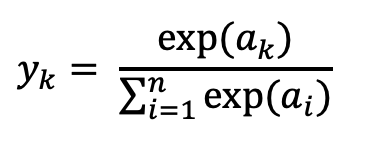

위와 같은 식으로 표현되는 함수이며 시그모이드 함수와 마찬가지로 출력으로 확률값을 내주는 성질을 갖는다.


소프트맥스함수는 입력 중에서 가장 큰 값의 확률이 가장 크도로 출력한다

즉 파이토치의 레이어 함수인 선형함수와 소프트맥스 함수를 이어 붙이면 여러 확률 값을 반환하는 예측모델을 구성할 수 있다.

**교차 엔트로피 함수**

교차 엔트로피 함수는 소프트맥스 함수의 중간 텐서 안의 모든 요소들에 대해 로그를 취해 정답 요소만을 골라낸다.

손실함수로 넘겨줄 정답인 두번쨰 인수는 반드시 정수값으로 이루어져야한다.


# **07.다중분류 실습**

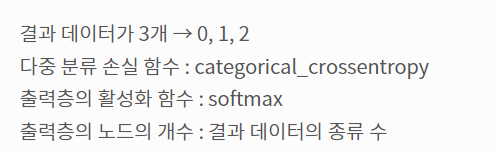

지난번 실습과 다르게 이번에는 클래스가 3가지 이상이다.

이런 경우에는 시그모이드 함수가 아닌 소프트맥스 함수를 사용해야한다.

데이터 불러오기

In [6]:
# 학습용 데이터 준비

# 라이브러리 임포트
from sklearn.datasets import load_iris

# 데이터 불러오기
iris = load_iris()

# 입력 데이터와 정답 데이터
x_org, y_org = iris.data, iris.target

# 결과 확인
print('원본 데이터', x_org.shape, y_org.shape)

원본 데이터 (150, 4) (150,)


우리가 사용할 데이터셋은 머신러닝과 통계 분야에서 오래전부터 사용해온 붓꽃iris 데이터셋이다

이 데이터는 scikit-learn의 datasets 모듈에 포함되어 있기에 라이브러리를 임포트 해온 후

load_iris 함수를 사용해서 데이터를 불러와 결과를 확인해보면 데이터셋에는 총 150개의 데이터가 담겨있고, 각 데이터에는 4개의 정보(sepal,petal의 길이(length)와 폭(width))가 담겨있는것을 확인할 수 있습니다)

**데이터 추출**

In [7]:
# data는 꽃잎의 길이와 폭, 꽃받침의 길이와 폭을 수치 값으로 가지고 있는 NumPy 배열이다.
# 입력 데이터로 sepal(꽃받침) length(0)와 petal(꽃잎) length(2)를 추출
x_select = x_org[:,[0,2]]     #행렬의 특정 열들을 선택하는 표기법

# 결과 확인
print('원본 데이터', x_select.shape, y_org.shape)

원본 데이터 (150, 2) (150,)


In [8]:
# 훈련 데이터와 검증 데이터로 분할(셔플도 동시에 실시함)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_select, y_org, train_size=75, test_size=75,
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 2) (75, 2) (75,) (75,)


이 코드는 Scikit-learn 라이브러리의 train_test_split 함수를 사용하여 데이터셋을 학습용 데이터와 테스트용 데이터로 나누는 과정을 수행하는 코드입니다.


train_size=75와 test_size=75는 각각 훈련용 데이터와 테스트용 데이터의 크기를 나타냅니다. 즉, 데이터를 75개씩 훈련 데이터와 테스트 데이터로 나누겠다는 의미입니다.

random_state=123은 난수 발생 시드(seed)를 설정하는 부분입니다. 이 값을 설정하면 난수 발생이 고정되어, 동일한 데이터셋을 여러 번 나눌 때도 항상 같은 결과가 나오게 됩니다.

이렇게 데이터를 나누는 이유는 모델을 훈련시키고 나서, 테스트용 데이터를 사용하여 모델의 성능을 평가하기 위함입니다.

In [9]:
# 데이터를 정답별로 분할

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

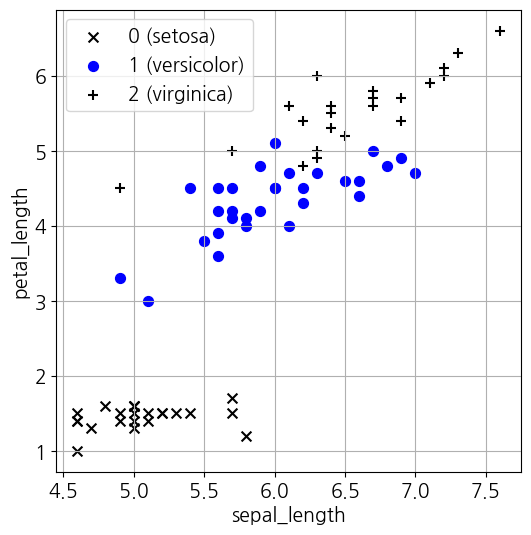

In [10]:
# 산포도 출력
# 훈련데이터를 정답데이터에 따라 그룹으로 나워 산포도로 출력한 결과

plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolor)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()

산포도 출력 결과를 확인해보면, 세 종류의 데이터는 직선으로 어느 정도까지는 그룹으로 나눌 수 있을 듯 보인다

# **모델 정의**

데이터 준비가 끝났으므로 모델 정의

In [11]:
# 학습용 파라미터 설정

# 입력 차원수
n_input = x_train.shape[1]

# 출력 차원수
# 분류 클래스 수, 여기서는 3
n_output = len(list(set(y_train)))

# 결과 확인
print(f'n_input: {n_input}  n_output: {n_output}')

n_input: 2  n_output: 3


앞의 이중분류에서는 2입력1출력
여기서는 출력차원수가 3으로 바뀜

(결과값이 여러개)

In [12]:
# 2입력 3출력 로지스틱 회귀 모델 정의

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)

        # 초깃값을 모두 1로 함
        # "딥러닝을 위한 수학"과 조건을 맞추기 위한 목적
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        return x1

# 인스턴스 생성
net = Net(n_input, n_output)

이 코드에서 중요한 부분은 forward함수 정의부분

앞의 이진 분류에서는  입력텐서를 선형함수에 적용한 결과에, 시그모이드 함수를 다시 적용한 다음 얻은 결과를 출력으로 하고 있는 반면

다중분류에서는 활성화함수 호출 부분이 사라지고 단순히 선형함수의 결과를 반환하고 있다

이는 손실함수가 활성화함수를 커버하고 있기 때문이다



In [13]:
# 모델 내부 파라미터 확인
# l1.weight는 행렬, l1.bias는 벡터

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1., 1., 1.], requires_grad=True))


결과를 확인해보면 3행 2열안 행렬로 3차원 백터라는 사실을 확인할 수 있따

최적의 알고리즘과 손실 함수의 정의

In [14]:
# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 경사하강법

보통 딥러닝에서는 입력 데이터나 가중치와 같은 연산을 위해 부동 소수점 타입인 float를 사용하는 것이 일반적입니다.

하지만 분류 문제에서 레이블과 같은 정수 값을 다루기 위해 long 타입으로 변환하는 경우도 있습니다.

In [15]:
# 입력 데이터 x_train과 정답 데이터 y_train의 텐서 변수화

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 검증 데이터의 텐서 변수화

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

경사하강법의 첫 단계는 학습데이터를 텐서변수로 바꾸는 것이다.
long함수를 사용한다

**long() 함수는** PyTorch에서 사용되는 데이터 타입 변환 함수 중 하나입니다.

PyTorch는 텐서 연산을 수행하는 라이브러리로, 텐서는 다차원 배열을 나타내는 데이터 구조입니다.

텐서의 요소(element)들은 숫자로 구성되며, 이 숫자의 데이터 타입은 float, int, long 등이 있습니다.

long() 함수는 텐서의 데이터 타입을 64비트 정수(integer)로 변환합니다.

따라서 특정 데이터 타입의 텐서를 long 타입으로 변환하고자 할 때 사용합니다.

long() 함수의 결과로 변환된 텐서는 모든 요소가 64비트 정수로 이루어진 텐서가 됩니다.

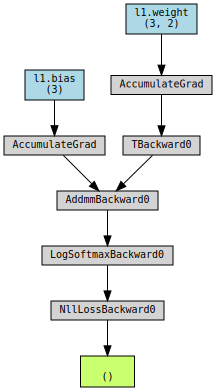

In [16]:
# 손실의 계산 그래프 시각화
# 예측 계산
outputs = net(inputs)

# 손실 계산
loss = criterion(outputs, labels)

# 손실의 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

예측라벨 얻는 방벙

In [17]:
# torch.max 함수 호출
# 2번째 인수는 축을 의미함. 1이면 행별로 집계
print(torch.max(outputs, 1))

torch.return_types.max(
values=tensor([12.0000, 12.7000,  7.6000, 13.0000, 12.3000,  7.6000,  7.3000, 11.1000,
        12.1000, 13.3000,  8.0000,  7.0000, 10.3000,  7.6000, 11.7000, 13.3000,
         7.4000, 13.5000,  8.2000,  8.4000, 12.7000,  6.6000,  7.9000, 12.2000,
        14.6000, 12.0000, 10.2000, 10.5000,  7.1000,  7.3000, 12.6000, 12.7000,
         7.4000,  7.7000, 10.8000, 11.5000, 11.5000, 14.0000, 12.8000, 10.8000,
        10.8000, 15.2000,  7.5000,  7.8000, 11.1000, 13.6000, 12.9000, 14.2000,
        12.7000,  7.6000, 10.9000,  7.0000, 10.9000, 11.2000,  7.4000, 11.7000,
        13.3000, 11.5000, 13.4000, 12.7000,  7.7000, 11.8000,  7.0000, 12.6000,
        11.7000, 10.9000,  9.2000, 12.2000, 10.4000, 12.1000,  7.5000,  9.1000,
        11.1000, 12.0000, 14.3000], grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

코드는 PyTorch에서 출력된 텐서 outputs에서 각 행마다 최댓값과 그에 해당하는 인덱스를 계산하여 출력하는 코드입니다.

In [18]:
# 예측 라벨 리스트를 취득
torch.max(outputs, 1)[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

반복계산

이제 경사 하강법을 반복 계산한다

In [19]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 평가 결과 기록
history = np.zeros((0,5))

In [20]:
# 반복 계산 메인 루프

for epoch in range(num_epochs):

    # 훈련 페이즈

    # 경사 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    # 경사 계산
    loss.backward()

    # 파라미터 수정
    optimizer.step()

    # 예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]

    # 손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    # 예측 페이즈

    # 예측 계산
    outputs_test = net(inputs_test)

    # 손실 계산
    loss_test = criterion(outputs_test, labels_test)

    # 예측 라벨 산출
    predicted_test = torch.max(outputs_test, 1)[1]

    # 손실과 정확도 계산
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)

    if ((epoch) % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09263, val_acc: 0.26667
Epoch [10/10000], loss: 1.03580 acc: 0.40000 val_loss: 1.06403, val_acc: 0.26667
Epoch [20/10000], loss: 1.00477 acc: 0.40000 val_loss: 1.03347, val_acc: 0.26667
Epoch [30/10000], loss: 0.97672 acc: 0.40000 val_loss: 1.00264, val_acc: 0.26667
Epoch [40/10000], loss: 0.95057 acc: 0.41333 val_loss: 0.97351, val_acc: 0.26667
Epoch [50/10000], loss: 0.92616 acc: 0.48000 val_loss: 0.94631, val_acc: 0.38667
Epoch [60/10000], loss: 0.90338 acc: 0.69333 val_loss: 0.92098, val_acc: 0.56000
Epoch [70/10000], loss: 0.88212 acc: 0.70667 val_loss: 0.89740, val_acc: 0.60000
Epoch [80/10000], loss: 0.86227 acc: 0.70667 val_loss: 0.87545, val_acc: 0.61333
Epoch [90/10000], loss: 0.84373 acc: 0.70667 val_loss: 0.85500, val_acc: 0.62667
Epoch [100/10000], loss: 0.82640 acc: 0.70667 val_loss: 0.83594, val_acc: 0.62667
Epoch [110/10000], loss: 0.81019 acc: 0.72000 val_loss: 0.81815, val_acc: 0.62667
Epoch [120/10000], loss: 0.

결과확인

In [21]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기상태 : 손실 : 1.09263  정확도 : 0.26667
최종상태 : 손실 : 0.19795  정확도 : 0.96000


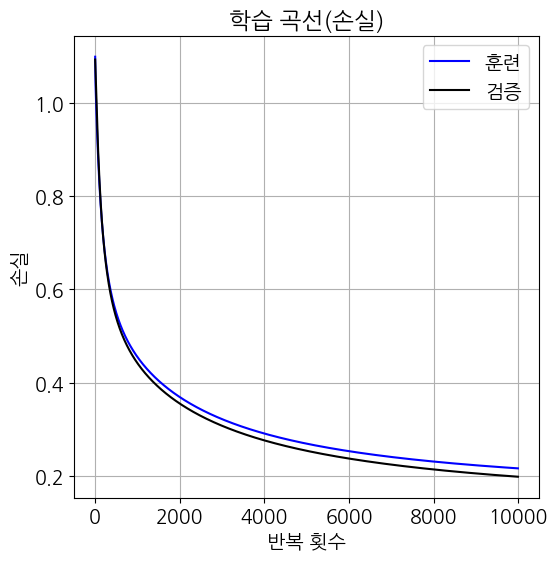

In [22]:
# 학습 곡선 출력(손실)

plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

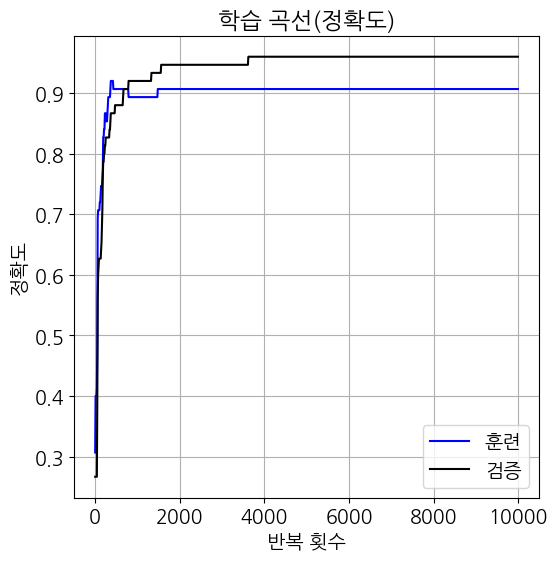

In [23]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,2], 'b', label='훈련')
plt.plot(history[:,0], history[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

# **모델출력확인**

모델 출력 확인은 딥러닝 모델이 입력 데이터에 대해 어떤 출력을 생성하는지를 평가하고 분석하는 과정을 말합니다.

딥러닝 모델은 입력 데이터를 받아들여 내부적으로 여러 계산을 거쳐 예측, 분류, 생성 등 다양한 작업을 수행하며 출력을 생성합니다.

이 출력이 모델의 성능과 품질을 나타내는 중요한 요소 중 하나입니다.

모델 출력 확인은 주로 시각화, 오차 분석, 평가 지표 계산 등을 통해 이루어집니다.

In [24]:
# 정답 데이터의 0번째, 2번째, 3번째를 추출

print(labels[[0,2,3]])

tensor([1, 0, 2])


labels 텐서에서 인덱스 0, 2, 3에 해당하는 클래스 레이블을 출력합니다.

In [25]:
# 이에 해당하는 입력값을 추출

i3 = inputs[[0,2,3],:]
print(i3.data.numpy())

[[6.3 4.7]
 [5.  1.6]
 [6.4 5.6]]


 inputs 텐서에서 인덱스 0, 2, 3에 해당하는 입력 데이터를 선택하여 i3라는 텐서로 저장합니다.

 위에서 선택한 입력 데이터 i3를 NumPy 배열로 변환하여 출력합니다.

In [26]:
# 출력값에 소프트맥스 함수를 적용한 결과를 취득

softmax = torch.nn.Softmax(dim=1)
o3 = net(i3)
k3 = softmax(o3)
print(o3.data.numpy())
print(k3.data.numpy())

[[ 8.8071 14.1938 12.9986]
 [12.8262  9.8     0.1734]
 [ 6.7954 15.0928 17.1111]]
[[0.0035 0.765  0.2315]
 [0.9537 0.0463 0.    ]
 [0.     0.1173 0.8827]]


Softmax 함수를 이용하여 확률값으로 변환하는 과정입니다.

 net은 딥러닝 모델을 나타내는 객체로, i3 입력을 통해 모델의 출력 o3를 계산하고, 이를 softmax 함수를 사용하여 확률값 k3로 변환합니다.

가중치 행렬과 바이어스 값

In [27]:
# 가중치 행렬
print(net.l1.weight.data)

# 바이어스
print(net.l1.bias.data)

tensor([[ 3.0452, -2.5735],
        [ 1.3573,  0.8481],
        [-1.4026,  4.7253]])
tensor([ 1.7178,  1.6563, -0.3741])


모델 내의 첫 번째 레이어의 가중치(weight)와 편향(bias)을 출력합니다.

이 코드는 모델의 입력, 출력, 가중치, 편향 등을 확인하여 모델의 동작과 결과를 분석하는 과정을 보여주고 있습니다.

이를 통해 모델이 입력 데이터에 대해 어떤 출력을 생성하고, 가중치와 편향의 값이 어떻게 되는지 등을 확인하며 모델을 이해하고 개선하는 데 활용할 수 있습니다.

7.12 입력 변수의 4차원화

추가로, 입력항목을 2번째 항목부터 4번째 항목까지 늘렸을 경우 결과가 어떻게 되는지 확인해보는 것

In [28]:
# 훈련 데이터와 검증 데이터로 분할(셔플도 동시에 실시함)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_org, y_org, train_size=75, test_size=75,
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# 입력 차원수
n_input = x_train.shape[1]

(75, 4) (75, 4) (75,) (75,)


In [29]:
print('입력 데이터(x)')
print(x_train[:5,:])
print(f'입력 차원수: {n_input}')

입력 데이터(x)
[[6.3 3.3 4.7 1.6]
 [7.  3.2 4.7 1.4]
 [5.  3.  1.6 0.2]
 [6.4 2.8 5.6 2.1]
 [6.3 2.5 5.  1.9]]
입력 차원수: 4


In [30]:
# 입력 데이터 x_train과 정답 데이터 y_train의 텐서 변수화
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 검증용 데이터의 텐서 변수화
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [31]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 알고리즘: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 평가 결과 기록
history = np.zeros((0,5))

In [32]:
for epoch in range(num_epochs):

    # 훈련 페이즈

    # 경사 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    # 경사 계산
    loss.backward()

    # 파라미터 수정
    optimizer.step()

    # 예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]

    # 손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    # 예측 페이즈

    # 예측 계산
    outputs_test = net(inputs_test)

    # 손실 계산
    loss_test = criterion(outputs_test, labels_test)

    # 예측 라벨 산출
    predicted_test = torch.max(outputs_test, 1)[1]

    # 손실과 정확도 계산
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)

    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [10/10000], loss: 1.01848 acc: 0.40000 val_loss: 1.04171, val_acc: 0.26667
Epoch [20/10000], loss: 0.96854 acc: 0.40000 val_loss: 0.98850, val_acc: 0.26667
Epoch [30/10000], loss: 0.92459 acc: 0.65333 val_loss: 0.93996, val_acc: 0.57333
Epoch [40/10000], loss: 0.88568 acc: 0.70667 val_loss: 0.89704, val_acc: 0.62667
Epoch [50/10000], loss: 0.85120 acc: 0.70667 val_loss: 0.85918, val_acc: 0.62667
Epoch [60/10000], loss: 0.82059 acc: 0.70667 val_loss: 0.82572, val_acc: 0.62667
Epoch [70/10000], loss: 0.79335 acc: 0.72000 val_loss: 0.79607, val_acc: 0.62667
Epoch [80/10000], loss: 0.76900 acc: 0.72000 val_loss: 0.76968, val_acc: 0.65333
Epoch [90/10000], loss: 0.74717 acc: 0.72000 val_loss: 0.74610, val_acc: 0.65333
Epoch [100/10000], loss: 0.72750 acc: 0.76000 val_loss: 0.72494, val_acc: 0.69333
Epoch [110/10000], loss: 0.70970 acc: 0.77333 val_loss: 0.70585, val_acc: 0.74667
Epoch [120/10000], loss: 0.

In [33]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기상태 : 손실 : 1.09158  정확도 : 0.26667
최종상태 : 손실 : 0.13724  정확도 : 0.96000


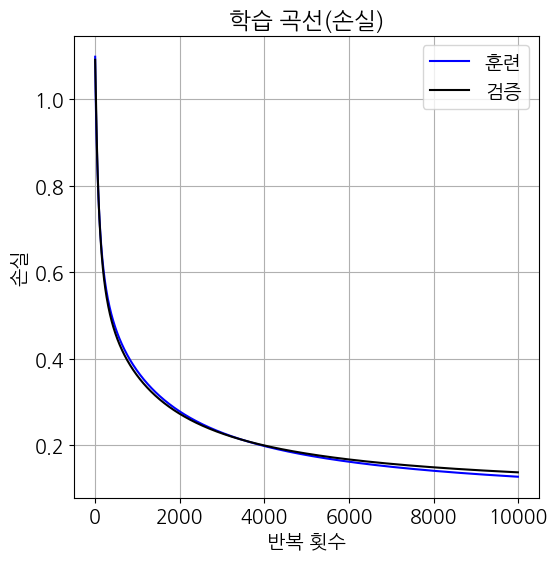

In [34]:
# 학습 곡선 출력(손실)

plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

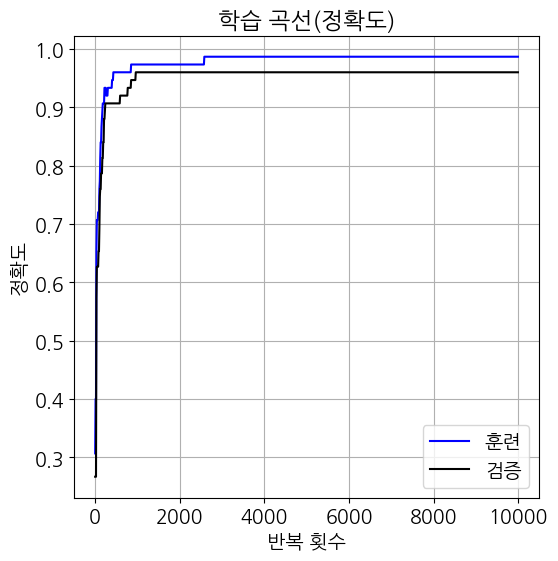

In [35]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,2], 'b', label='훈련')
plt.plot(history[:,0], history[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()